# Churn Prediction - Telecom Case
Author: Daniel Grzebyk

Date: 1.07.2022

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

## Loading the data

In [2]:
df = pd.read_csv("data/telecom/data.csv")
var_df = pd.read_csv("data/telecom/variables-definition.csv")

## Exploratory Data Analysis (EDA)
Research Question: Why customers leave the company?

Hypothesis to be verified:
- the services are too expensive - if yes, then lower income households would leave more frequently, as they are more price-sensitive
- the services are not required - if yes, few calls, low data usage, etc.
- low quality of service - many calls failed due to network issues
- geography: maybe in some geographical areas (lower network coverage or income)
- are household with children more loyal customers?

Relevant Observations:
- Data Structure: every row is a customer / household
- Problem: binary classification problem: predict whether a customer will stay with the telecom company or leave
- Label: churn - the customer will leave [yes / no]

Interesting features
- Failed calls might indicate issues with the quality of service. What % of all calls fails, and how does it influence customer loyalty?
- Time spent calling customer service, happy customers rarely call.

Features not relevant for predicting churn:
- Number and minutes of unanswered and received calls
- Whether calls are wireless or not
- Network traffic, whether call is peak or off-peak
- The number of call participants
- Whether calls are incoming or outbound
- Distinction between voice and data calls

In [3]:
features_eliminated = ['Customer_ID', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean',
                       'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
                       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 
                       'mou_cdat_Mean', 'mou_rvce_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean',
                       'callwait_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean',
                       'cc_mou_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'roam_Mean',
                       'ethnic']

df.drop(columns=features_eliminated, inplace=True)
# Knowing number of calls and their mean time, average time per call can be calculated

In [4]:
df.shape

(100000, 66)

### Loyalty
The distribution is right-skewed, peak around the 12th month might indicate past sale or a marketing campaign. The longest staying customer is with the company for 5 years. 

<AxesSubplot:xlabel='months', ylabel='Count'>

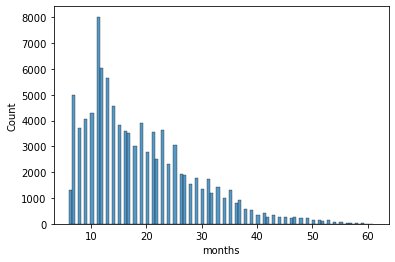

In [5]:
sns.histplot(df['months'])

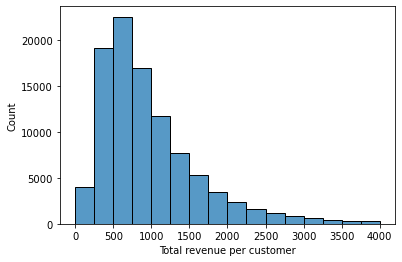

In [6]:
sns.histplot(df['totrev'], binrange=(0, 4000), binwidth=250)
plt.xlabel("Total revenue per customer")
plt.show()

### Company Revenue
As customer requirements are covered by multiple products, in order to check which customers significantly changed their consumption it is the easiest to look at the revenue. It can be seen that around 5% of all customers reduced their spending by at least 50% with respect to the 3 month mean. These customers might be the potential leavers.

After identifying who the potential leavers might be, it will be checked what % of revenue they bring to the company. E.g. suddent outflow of high-revenue clients could be a source of a major concern.

In [7]:
rapid_reduction_rate = round(len(df['change_rev'].loc[df['change_rev'] < -50]) / len(df), 2)
rapid_reduction_rate

0.05

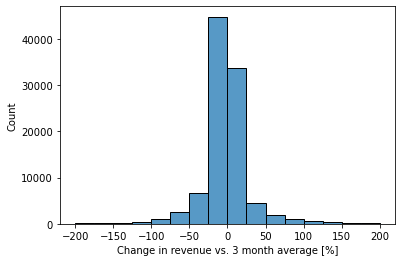

In [8]:
sns.histplot(df['change_rev'], binrange=(-200, 200), binwidth=25)
plt.xlabel("Change in revenue vs. 3 month average [%]")
plt.show()

Customers who use more than they declared in their plan often bear additional costs. Are these costs the reason why they change the service provider? Probably not, as they are usually less than 10% of the overall costs.

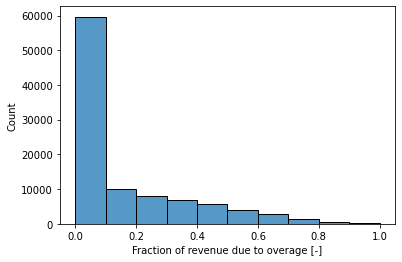

In [9]:
df['overrev_ratio'] = df['ovrrev_Mean'] / df['rev_Mean']
sns.histplot(df['overrev_ratio'], binrange=(0, 1), binwidth=0.1)
plt.xlabel("Fraction of revenue due to overage [-]")
plt.show()

Clearly, there are very few customers who pay for the service and not use it. Therefore, rapid drop of demand might be correlated with churn.

<AxesSubplot:xlabel='actsubs_ratio', ylabel='Count'>

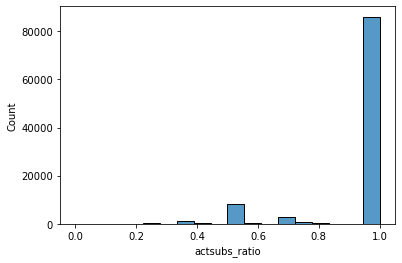

In [10]:
df['actsubs_ratio'] = df['actvsubs'] / df['uniqsubs']
sns.histplot(df['actsubs_ratio'])

### Customers social status
Clients' income is a categorical variable, but no information about the brackets for each class were provided. It is assumed that income will be the most influencial of all status-related features including also: size of dwelling, credit card information, number of cars, etc. 

In [11]:
df['income'].value_counts()

6.0    18802
7.0    11597
9.0    10833
5.0     8277
4.0     7790
3.0     5830
8.0     5142
1.0     4033
2.0     2260
Name: income, dtype: int64

### Household information
How many households have children, and are households with children more loyal customers? The initial hypothesis is the parents of young children are too busy to make changes in telecom providers, but this tendency is expected to disappear as children are older.

<AxesSubplot:xlabel='totmrc_Mean', ylabel='Count'>

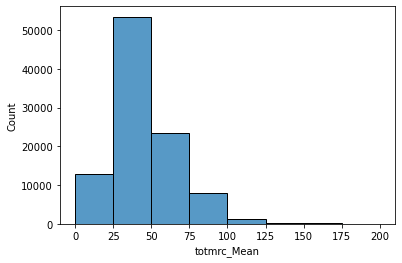

In [12]:
sns.histplot(df['totmrc_Mean'], binrange=(0, 200), binwidth=25)

In [66]:
df.groupby('kid0_2')['churn'].sum() / df.groupby('kid0_2').size()

kid0_2
U    0.494918
Y    0.519442
dtype: float64

In [67]:
df.groupby('marital')['churn'].sum() / df.groupby('marital').size()

marital
A    0.489689
B    0.496908
M    0.488664
S    0.474670
U    0.512656
dtype: float64

### Quality of service
Median time of a call with customer service is 2 min which might mean the issues are resolved relatively quickly.

In [13]:
(df['ccrndmou_Mean'] / df['custcare_Mean']).median()

2.000000003

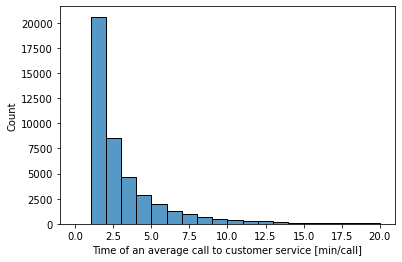

In [14]:
sns.histplot(df['ccrndmou_Mean'] / df['custcare_Mean'], binrange=(0, 20), binwidth=1)
plt.xlabel("Time of an average call to customer service [min/call]")
plt.show()

High percentage of failed calls or old equipment could indicate low quality of service and influence customer churn. It does not matter whether headset is refurbished or new, churn value is ~50%. 

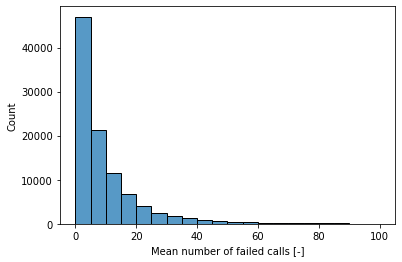

In [15]:
failed_calls = df['drop_vce_Mean'] + df['drop_dat_Mean'] + df['blck_vce_Mean'] + df['blck_dat_Mean']
sns.histplot(failed_calls, binrange=(0, 100), binwidth=5)
plt.xlabel("Mean number of failed calls [-]")
plt.show()

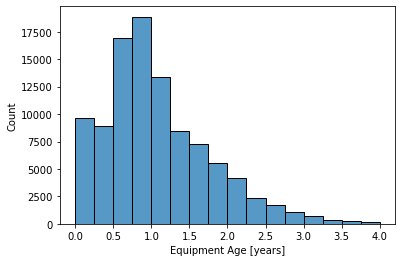

In [16]:
sns.histplot(df['eqpdays'] / 365, binrange=(0, 4), binwidth=0.25)
plt.xlabel("Equipment Age [years]")
plt.show()

In [17]:
df.groupby("refurb_new")['churn'].sum() / df.groupby('refurb_new').size()

refurb_new
N    0.489105
R    0.534361
dtype: float64

### Other
Churn is more or less equally distributed across all areas of operation. Non-uniform distribution could undicate e.g. new strong competition. 

In [18]:
df['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

In [19]:
df.groupby('area')['churn'].sum() / df.groupby('area')['churn'].size()

area
ATLANTIC SOUTH AREA              0.489726
CALIFORNIA NORTH AREA            0.521055
CENTRAL/SOUTH TEXAS AREA         0.478483
CHICAGO AREA                     0.495234
DALLAS AREA                      0.487468
DC/MARYLAND/VIRGINIA AREA        0.460332
GREAT LAKES AREA                 0.476447
HOUSTON AREA                     0.475006
LOS ANGELES AREA                 0.498192
MIDWEST AREA                     0.459029
NEW ENGLAND AREA                 0.517425
NEW YORK CITY AREA               0.500270
NORTH FLORIDA AREA               0.520000
NORTHWEST/ROCKY MOUNTAIN AREA    0.569085
OHIO AREA                        0.463755
PHILADELPHIA AREA                0.506541
SOUTH FLORIDA AREA               0.533613
SOUTHWEST AREA                   0.510102
TENNESSEE AREA                   0.471319
Name: churn, dtype: float64

In [20]:
df.groupby('new_cell')['churn'].sum() / df.groupby('new_cell').size()

new_cell
N    0.496627
U    0.496951
Y    0.490285
dtype: float64

## Data Preprocessing

In [21]:
X = df.drop(columns=['churn']).copy()
y = df['churn'].copy()

### Looking for duplicates

In [22]:
X.duplicated().sum()

0

### Dropping NaNs

In [23]:
# Count NaNs
nans_per_feature = X.isna().sum()
nans_per_feature[nans_per_feature > 30000]  # Is one of the dropped features crucial?

ownrent     33706
lor         30190
dwlltype    31909
numbcars    49366
HHstatin    37923
dwllsize    38308
dtype: int64

In [24]:
cols_to_drop = list(nans_per_feature[nans_per_feature > 30000].index)  # drop features which have more than 20% NaNs
X.drop(columns=cols_to_drop, inplace=True)
print("Dropping:", cols_to_drop)

print("Before dropping rows with NaNs:", X.shape)
X.dropna(inplace=True)
y = y.loc[X.index]
print("After dropping rows with NaNs:", X.shape)

Dropping: ['ownrent', 'lor', 'dwlltype', 'numbcars', 'HHstatin', 'dwllsize']
Before dropping rows with NaNs: (100000, 61)
After dropping rows with NaNs: (60384, 61)


### Identifying numerical, categorical, text features

In [35]:
X.select_dtypes(include='number').columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'datovr_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean',
       'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'custcare_Mean',
       'ccrndmou_Mean', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'totrev',
       'avgrev', 'avgmou', 'avgqty', 'hnd_price', 'phones', 'models', 'truck',
       'rv', 'adults', 'income', 'forgntvl', 'eqpdays', 'overrev_ratio',
       'actsubs_ratio'],
      dtype='object')

In [36]:
X.select_dtypes(include='object').columns

Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'marital', 'infobase', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

In [37]:
X.select_dtypes(include='category').columns

Index([], dtype='object')

In [38]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

In [39]:
len(num_features) + len(cat_features)

49

In [40]:
len(cols_to_drop)

6

### Looking for correlations

In [41]:
num_features

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'datovr_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean',
       'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'custcare_Mean',
       'ccrndmou_Mean', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'totrev',
       'avgrev', 'avgmou', 'avgqty', 'hnd_price', 'phones', 'models', 'truck',
       'rv', 'adults', 'income', 'forgntvl', 'eqpdays', 'overrev_ratio',
       'actsubs_ratio'],
      dtype='object')

<AxesSubplot:>

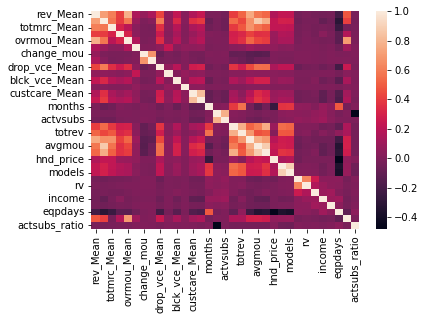

In [42]:
corr = df[num_features].corr()
sns.heatmap(corr)

In [43]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
X.drop(to_drop, axis=1, inplace=True)

In [45]:
# Re-assigning numerical features after dropping the correlated ones
num_features = X.select_dtypes(include='number').columns

### Looking for class imbalance

In [46]:
y.value_counts()

0    31584
1    28800
Name: churn, dtype: int64

## Predicting churn

### Splitting the data

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# For simplicity I am skipping the test (left-out) set, I would prefer to use 60%-20%-20% data split

### Training the model

In [ ]:
# I did not identify text features
ct = make_column_transformer((StandardScaler(), num_features),
                             (OneHotEncoder(handle_unknown='ignore'), cat_features),
                             n_jobs=-1,
                             verbose=False)

pipeline = Pipeline(
    steps=[("preprocessor", ct), ("regressor", RandomForestClassifier())] # LogisticRegression(max_iter=500)
)

# Training the model
pipeline.fit(X_train, y_train)

In [ ]:
# Train Inference
y_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

In [ ]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

## Error Analysis / Postprocessing

In [86]:
# Get the coefficients of each feature
coefs = model.named_steps["classifier"].coef_.flatten()

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature", y="value", data=df.head(20), palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

ValueError: All arrays must be of the same length

## Cusomer segmentation

In [ ]:
# 1. Use Elbow method to find the number of distinct customer groups
# 2. For every cluster separately check the % of leavers
data

In [ ]:
%%time
distorsions = []

data = X[num_features].copy()

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    distorsions.append(kmeans.inertia_)

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)
plt.title('Elbow curve')
plt.show()

Using the Elbow Method I identify the optimal number of clusters to be 5 and retrain KMeans on it.

What does this information give me? What if the elbow method identifies 100 clusters? How will it help me identify churners? I cannot investigate 100 clusters manually.

PCA is not an option, because it loses variance.

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)

In [ ]:
data['cluster_no'] = kmeans.labels_

In [ ]:
plt.scatter()